In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from datetime import date, timedelta
from scipy import stats
import scipy.optimize as sco
from sklearn.decomposition import PCA
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
symbol = pd.read_csv("nasdaq_stocks.csv")
symbol_dict = dict(zip(symbol["Name"], symbol["Symbol"]))
#stocks = ["Apple Inc.", "Amazon.com Inc.", "Alphabet Inc.", "Netflix Inc.", "Tesla Inc."]
stocks = random.sample(list(symbol_dict.keys()), 10)
stocks = [symbol_dict[i] for i in stocks]

In [3]:
stocks = ['ALRS', 'DKL', 'KRNT', 'MTH', 'MYD', 'POOL', 'RSG']
stocks

['ALRS', 'DKL', 'KRNT', 'MTH', 'MYD', 'POOL', 'RSG']

In [4]:
data = pdr.get_data_yahoo(stocks, start=date.today()-timedelta(365*6), end=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  7 of 7 completed


In [5]:
list(set(data.columns) - set(data.dropna(axis=1).columns))

[]

In [6]:
data = data.dropna(axis=1)

In [7]:
data

,ALRS,DKL,KRNT,MTH,MYD,POOL,RSG
Date,,,,,,,
2016-09-07,14.999019,15.885192,10.650000,36.730000,11.761921,93.372421,45.354671
2016-09-08,14.999019,15.320214,10.420000,36.369999,11.776610,92.233971,45.408279
2016-09-09,14.852812,15.089833,9.890000,34.720001,11.673761,89.364296,44.238003
2016-09-12,14.852812,15.457347,9.390000,35.410000,11.644374,90.004074,44.908001
2016-09-13,14.852812,15.479282,9.510000,34.250000,11.579429,88.498680,44.631062
...,...,...,...,...,...,...,...
2021-08-30,28.999746,39.221645,131.740005,112.260002,14.593677,487.242645,122.536530
2021-08-31,29.136354,39.979820,130.369995,111.540001,14.555595,490.088196,122.398468
2021-09-01,28.472836,39.526768,129.800003,113.930000,14.584155,487.044403,123.078850


In [8]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

def neg_prob_sharpe_ratio(weights, mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (p_ret - risk_free_rate)/p_var
    coskew = pd.Series(stats.skew(mean_returns), index=mean_returns.index).mean()
    cokurt = pd.Series(stats.kurtosis(mean_returns, fisher=False), index=mean_returns.index).mean()    
    sharpe_ratio_stdev = np.sqrt((1+(0.5*sharpe_ratio**2) - coskew*sharpe_ratio) + (((cokurt-3)/4)*sharpe_ratio**2))/(len(mean_returns)-1)
    prob_sharpe_ratio = stats.norm.cdf((sharpe_ratio - sharpe_ratio_benchmark)/sharpe_ratio_stdev)
    return -1*prob_sharpe_ratio

def max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_prob_sharpe_ratio, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({"type": "eq", "fun": lambda x: portfolio_return(x) - target}, {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [9]:
# Select stocks with negative weights less than 50%
returns = data.pct_change()
pca = PCA(1).fit(returns.fillna(0))
pc1 = pd.Series(index=returns.columns, data=pca.components_[0])
to_select = pc1.nlargest()[pc1.nlargest()/pc1.nlargest().sum() * 100 < 50]
data = data[to_select.index]

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178
log_returns = np.log(data/data.shift(1))
log_returns = log_returns.dropna()

In [10]:
max_sharpe = max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=1.0)
sdp, rp = portfolio_annualized_performance(max_sharpe["x"], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe["x"], index=data.columns, columns=["allocation"])
max_sharpe_allocation["allocation"] = [round(i*100, 2)for i in max_sharpe_allocation["allocation"]]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualized_performance(min_vol["x"], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=["allocation"])
min_vol_allocation["allocation"] = [round(i*100,2)for i in min_vol_allocation["allocation"]]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns)*np.sqrt(252)
an_rt = mean_returns*252

In [11]:
print("\nMaximum Sharpe Ratio Portfolio Allocation")
print("Annualized Return:", round(rp, 2))
print("Annualized Volatility:", round(sdp, 2))
print(max_sharpe_allocation)

print("\nMinimum Volatility Portfolio Allocation")
print("Annualized Return:", round(rp_min, 2))
print("Annualized Volatility:", round(sdp_min, 2))
print(min_vol_allocation)

print("\nIndividual Stock Returns and Volatility")
for i, txt in enumerate(data.columns):
    print("{}: Annualized Return: {}; Annualized Volatility: {}".format(txt, round(an_rt[i], 2), round(an_vol[i], 2)))


Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.4
Annualized Volatility: 0.24
             DKL  MTH   KRNT   POOL    RSG
allocation  5.19  0.0  25.89  42.01  26.91

Minimum Volatility Portfolio Allocation
Annualized Return: 0.27
Annualized Volatility: 0.19
             DKL  MTH  KRNT   POOL    RSG
allocation  1.44  0.0  3.23  18.96  76.38

Individual Stock Returns and Volatility
DKL: Annualized Return: 0.32; Annualized Volatility: 0.54
MTH: Annualized Return: 0.33; Annualized Volatility: 0.46
KRNT: Annualized Return: 0.64; Annualized Volatility: 0.51
POOL: Annualized Return: 0.38; Annualized Volatility: 0.29
RSG: Annualized Return: 0.22; Annualized Volatility: 0.2


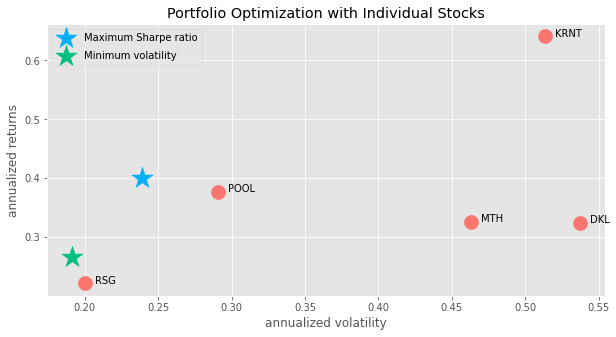

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(an_vol, an_rt, marker="o", color="#f8766d", s=200)

for i, txt in enumerate(data.columns):
    ax.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10, 0), textcoords="offset points")

ax.scatter(sdp, rp, marker="*", color="#01b0f6", s=500, label="Maximum Sharpe ratio")
ax.scatter(sdp_min, rp_min, marker="*", color="#02bf7d", s=500, label="Minimum volatility")

#target = np.linspace(rp_min, 0.34, 50)
#efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

#ax.plot([pf["fun"] for pf in efficient_portfolios], target, linestyle="-.", color="black", label="efficient frontier")
ax.set_title("Portfolio Optimization with Individual Stocks")
ax.set_xlabel("annualized volatility")
ax.set_ylabel("annualized returns")
ax.legend(labelspacing=0.8)
plt.show(fig)

In [13]:
df_test = pdr.get_data_yahoo(list(data.columns), start=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  5 of 5 completed


In [14]:
ret_sharpe = 0
for i in df_test.columns:
    ret_sharpe += df_test[i]*max_sharpe_allocation.reset_index(drop=True)[i][0]
ret_sharpe /= 100

ret_vol = 0
for i in df_test.columns:
    ret_vol += df_test[i]*min_vol_allocation.reset_index(drop=True)[i][0]
ret_vol /= 100

In [15]:
df_test = pdr.get_data_yahoo(list(data.columns), start=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  5 of 5 completed


In [16]:
df_test["MSP"] = ret_sharpe
df_test["MVP"] = ret_vol

In [17]:
if df_test.isna().sum().sum() > 0:
    df_test = df_test.dropna()

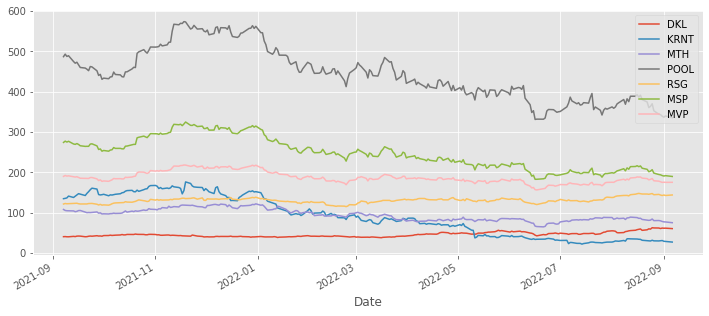

In [18]:
df_test.plot(figsize=(12,5),legend=True)
plt.show()

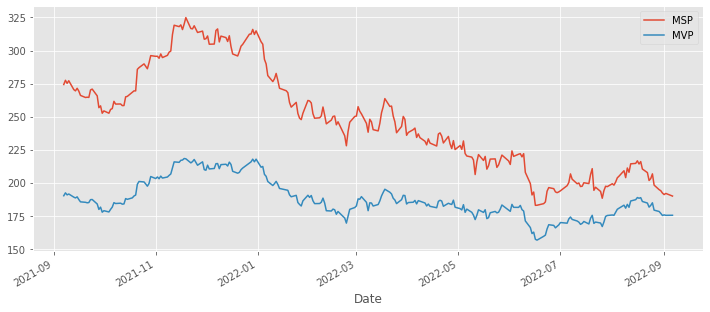

In [19]:
df_test[["MSP", "MVP"]].plot(figsize=(12,5),legend=True)
plt.show()

In [20]:
(df_test["MSP"][-1] - df_test["MSP"][0])/df_test["MSP"][0] * 100

-30.761753980739602

In [21]:
(df_test["MVP"][-1] - df_test["MVP"][0])/df_test["MVP"][0] * 100

-7.76167260370057

In [22]:
df_test

,DKL,KRNT,MTH,POOL,RSG,MSP,MVP
Date,,,,,,,
2021-09-07,40.664024,134.850006,108.089996,486.865906,121.619499,274.283317,190.143972
2021-09-08,40.904423,135.630005,105.650002,493.151917,122.881645,277.478119,192.328477
2021-09-09,40.432877,136.710007,104.970001,487.450928,122.260429,275.171103,190.801178
2021-09-10,40.377396,141.220001,104.820000,489.225616,122.506943,277.147758,191.470826
2021-09-13,41.431446,137.850006,104.500000,474.839264,123.088715,270.442819,189.093858
...,...,...,...,...,...,...,...
2022-08-30,60.840000,30.580000,79.940002,343.190002,143.839996,193.956221,176.797644
2022-08-31,62.009998,31.080000,78.349998,339.190002,142.720001,192.164603,175.216789
2022-09-01,61.610001,29.240000,77.400002,336.869995,143.970001,191.029207,175.666474
